In [2]:
import pandas as pd 
import numpy as np

import featuretools as ft

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Read in Data & Create Small Datasets
Only use first 1000 rows

In [4]:
df_size = 1000
app_train = pd.read_csv('../home-credit-default-risk/application_train.csv', nrows = df_size).sort_values('SK_ID_CURR').reset_index(drop = True)
app_test = pd.read_csv('../home-credit-default-risk/application_test.csv', nrows = df_size).sort_values('SK_ID_CURR').reset_index(drop = True)
bureau = pd.read_csv('../home-credit-default-risk/bureau.csv', nrows = df_size).sort_values(['SK_ID_CURR','SK_ID_BUREAU']).reset_index(drop = True)
bureau_balance = pd.read_csv('../home-credit-default-risk/bureau_balance.csv', nrows = df_size).sort_values('SK_ID_BUREAU').reset_index(drop = True)
cash = pd.read_csv('../home-credit-default-risk/POS_CASH_balance.csv', nrows = df_size).sort_values(['SK_ID_CURR','SK_ID_PREV']).reset_index(drop = True)
credit = pd.read_csv('../home-credit-default-risk/credit_card_balance.csv', nrows = df_size).sort_values(['SK_ID_CURR','SK_ID_PREV']).reset_index(drop = True)
previous = pd.read_csv('../home-credit-default-risk/previous_application.csv', nrows = df_size).sort_values(['SK_ID_CURR','SK_ID_PREV']).reset_index(drop = True)
installments = pd.read_csv('../home-credit-default-risk/installments_payments.csv', nrows = df_size).sort_values(['SK_ID_CURR','SK_ID_PREV']).reset_index(drop = True)

Join training and testing together after adding a seperate identifying column (may prevent data leakage)

In [5]:
app_train['set'] = 'train'
app_test['set'] = 'test'
app_test['TARGET'] = np.nan

app = app_train.append(app_test, ignore_index = True)

# Featuretools Basics

## Entities & Entitysets
+ An entity is like a dataframe with a unique index.  
+ An entityset is a collection of tables and the relationships between them. Using an entityset allows us to group together mmultiple tables and manipulate them much quicker than individual tables.

In [6]:
# Make an empty entityset named clients to keep track of all the data
es = ft.EntitySet(id = 'client')

Now we define each entity, or table of data. We need to pass in an index if the data has one or `make_index = True` if not. 

In [7]:
es = es.entity_from_dataframe(entity_id = 'app', dataframe = app, index = 'SK_ID_CURR')
es = es.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau, index = 'SK_ID_BUREAU')
es = es.entity_from_dataframe(entity_id = 'previous', dataframe = previous, index = 'SK_ID_PREV')
es = es.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = bureau_balance,
                              make_index = True, index = 'bureaubalance_index')
es = es.entity_from_dataframe(entity_id = 'cash', dataframe = cash,
                             make_index = True, index = 'cash_index')
es = es.entity_from_dataframe(entity_id = 'installments', dataframe = installments,
                             make_index = True, index = 'installments_index')
es = es.entity_from_dataframe(entity_id = 'credit', dataframe = credit,
                             make_index = True, index = 'credit_index')

## Relationships
Relationships are a fundamental concept not only in featuretools, but in any relational database. The best way to think of a one-to-many relationship is with the analogy of parent-to-child. A parent is a single individual, but can have mutliple children. The children can then have multiple children of their own. In a parent table, each individual has a single row. Each individual in the parent table can have multiple rows in the child table.

In [8]:
print('Parent: app, Parent Variable: SK_ID_CURR\n\n', app.iloc[:,111:115].head())
print('\nChild: bureau, Child Variable: SK_ID_CURR\n\n', bureau.iloc[10:30,1:5].head())

Parent: app, Parent Variable: SK_ID_CURR

    SK_ID_CURR  TARGET  TOTALAREA_MODE WALLSMATERIAL_MODE
0      100002     1.0          0.0149       Stone, brick
1      100003     0.0          0.0714              Block
2      100004     0.0             NaN                NaN
3      100006     0.0             NaN                NaN
4      100007     0.0             NaN                NaN

Child: bureau, Child Variable: SK_ID_CURR

     SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT
10       5715026        Active      currency 1         -454
11       5715028        Closed      currency 1         -265
12       5715029        Closed      currency 1         -339
13       5715070        Closed      currency 1        -1799
14       5715072        Closed      currency 1        -2022


Specify relationships and add them to the entityset

In [9]:
r_app_bureau = ft.Relationship(es['app']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])
r_bureau_balance = ft.Relationship(es['bureau']['SK_ID_BUREAU'], es['bureau_balance']['SK_ID_BUREAU'])
r_app_previous = ft.Relationship(es['app']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])
r_previous_cash = ft.Relationship(es['previous']['SK_ID_PREV'], es['cash']['SK_ID_PREV'])
r_previous_installments = ft.Relationship(es['previous']['SK_ID_PREV'], es['installments']['SK_ID_PREV'])
r_previous_credit = ft.Relationship(es['previous']['SK_ID_PREV'], es['credit']['SK_ID_PREV'])

In [10]:
es = es.add_relationships([r_app_bureau, r_app_previous, r_bureau_balance,
                          r_previous_cash, r_previous_credit, r_previous_installments])

es

Entityset: client
  Entities:
    app [Rows: 2000, Columns: 123]
    bureau [Rows: 1000, Columns: 17]
    previous [Rows: 1000, Columns: 37]
    bureau_balance [Rows: 1000, Columns: 4]
    cash [Rows: 1000, Columns: 9]
    installments [Rows: 1000, Columns: 9]
    credit [Rows: 1000, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    previous.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV

## Feature Primitives
A feature primitive is an operation applied to a table or a set of tables to create a feature. Feature primitives fall into two categories:

+ Aggregation: function that groups together child datapoints for each parent and then calculates a statistic such as mean, min, max, or standard deviation. An example is calculating the maximum previous loan amount for each client. An aggregation works across multiple tables using relationships between tables.
+ Transformation: an operation applied to one or more columns in a single table. An example would be taking the absolute value of a column, or finding the difference between two columns in one table.

In [12]:
# List the primitives in a dataframe
primitives = ft.list_primitives()
primitives

,name,type,description
0,percent_true,aggregation,Determines the percent of `True` values.
1,time_since_last,aggregation,Calculates the time elapsed since the last dat...
2,any,aggregation,Determines if any value is 'True' in a list.
3,min,aggregation,"Calculates the smallest value, ignoring `NaN` ..."
4,num_true,aggregation,Counts the number of `True` values.
...,...,...,...
73,minute,transform,Determines the minutes value of a datetime.
74,not,transform,Negates a boolean value.
75,week,transform,Determines the week of the year from a datetime.
76,modulo_by_feature,transform,Return the modulo of a scalar by each element ...


## Deep Feature Synthesis (DFS)

Deep Feature Synthesis (DFS) is the process featuretools uses to make new features. DFS stacks feature primitives to form features with a "depth" equal to the number of primitives. For example, if we take the maximum value of a client's previous loans (say `MAX(previous.loan_amount)`), that is a "deep feature" with a depth of 1. To create a feature with a depth of two, we could stack primitives by taking the maximum value of a client's average montly payments per previous loan (such as `MAX(previous(MEAN(installments.payment)))`). 

To perform DFS in featuretools, we use the dfs function passing it an `entityset`, the `target_entity` (where we want to make the features), the `agg_primitives` to use, the `trans_primitives` to use and the `max_depth` of the features. Here we will use the default aggregation and transformation primitives, a max depth of 2, and calculate primitives for the app entity.

### DFS with Default Primitives

In [18]:
# Default primitives
default_agg_primitives = ['sum', 'std', 'max', 'skew', 'min', 'mean', 'count', 'percent_true', 'num_unique', 'mode']
default_trans_primitives = ['day', 'year', 'month', 'weekday', 'haversine', 'num_words', 'num_characters']

# DFS with default primitives
feature_names = ft.dfs(entityset = es, target_entity = 'app',
                      trans_primitives = default_trans_primitives,
                      agg_primitives = default_agg_primitives,
                      max_depth = 2,
                      features_only = True) # features_only = True return only a list of the features and not calculate the features themselves

print('%d Total Features' % len(feature_names))

2221 Total Features


*Running following codes took around 24 hours on a computer with 64GB of ram*

In [ ]:
# feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'app',
#                       trans_primitives = default_trans_primitives,
#                       agg_primitives = default_agg_primitives,
#                       max_depth = 2, features_only = False, verbose = True)

# feature_matrix.head()

### DFS with specified primitives


In [19]:
feature_names = ft.dfs(entityset = es, target_entity = 'app',
                      agg_primitives = ['sum', 'count', 'min', 'max', 'mean', 'mode'],
                      max_depth = 2,
                      features_only = True) # features_only = True return only a list of the features and not calculate the features themselves
print('%d Total Features' % len(feature_names))

1215 Total Features


*Running following codes took around 12 hours on a computer with 64GB of ram*

In [ ]:
# feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'app',
#                       agg_primitives = ['sum', 'count', 'min', 'max', 'mean', 'mode'],
#                       max_depth = 2, features_only = False, verbose = True)

# feature_matrix.head()

# Results

## Model CV result
Using the model in the incremental training part 

|Features|No. of features|Val ROC AUC|Test ROC AUC|Time|
|:---:|:---:|:---:|:---:|:---:|
|only data in `application` dataset|241|0.760|0.745|0.25h|
|manual feature engineering using `application`, `bureau` and `bureau_balance` dataset|421|0.766|0.757|8h|
|manual feature engineering using all datasets|1465|0.785|0.783|12h|
|featuretools default features (in the `feature_matrix`)|1803|0.784|0.777|1h|
|featuretools specified features (in the `feature_matrix_spec`)|1156|0.786|0.779|1.25h|
|featuretools specified features & manual feature engineering|1624|0.787|0.782|13.25h|

## Correlations

In [20]:
correlations = pd.read_csv('../home-credit-default-risk/correlations_spec.csv',index_col = 0)
correlations.index.name = 'Variable'
correlations.head()

,SK_ID_CURR,FLAG_EMP_PHONE,DEF_60_CNT_SOCIAL_CIRCLE,LIVE_REGION_NOT_WORK_REGION,YEARS_BEGINEXPLUATATION_AVG,APARTMENTS_MODE,FLAG_MOBIL,FLOORSMIN_MEDI,BASEMENTAREA_AVG,LANDAREA_MODE,...,MODE(bureau.MODE(bureau_balance.STATUS))_0,MODE(bureau.MODE(bureau_balance.STATUS))_1,MODE(bureau.MODE(bureau_balance.STATUS))_2,MODE(bureau.MODE(bureau_balance.STATUS))_3,MODE(bureau.MODE(bureau_balance.STATUS))_5,MODE(bureau.MODE(bureau_balance.STATUS))_C,MODE(bureau.MODE(bureau_balance.STATUS))_X,MODE(previous_app.MODE(credit.NAME_CONTRACT_STATUS))_Active,MODE(previous_app.MODE(credit.NAME_CONTRACT_STATUS))_Completed,MODE(previous_app.MODE(credit.NAME_CONTRACT_STATUS))_Signed
Variable,,,,,,,,,,,,,,,,,,,,,
SK_ID_CURR,1.000000,-0.001337,0.001187,0.002903,0.001551,0.001961,0.002804,0.002837,-0.002070,0.001548,...,0.000571,0.000592,-0.001078,-0.001853,-0.002603,-0.000913,-0.000626,0.002259,-0.000788,0.000079
FLAG_EMP_PHONE,-0.001337,1.000000,-0.014034,0.096447,-0.008672,0.014720,-0.000845,0.016486,0.001292,0.008657,...,0.010976,0.003626,0.000845,0.000845,0.000577,-0.004562,-0.000096,0.061105,-0.003943,-0.000122
DEF_60_CNT_SOCIAL_CIRCLE,0.001187,-0.014034,1.000000,-0.016693,-0.004751,-0.015337,0.000499,-0.020663,-0.012925,-0.002882,...,0.005116,0.003296,-0.000499,-0.000499,0.005212,-0.000331,0.000605,0.007696,0.000246,-0.002226
LIVE_REGION_NOT_WORK_REGION,0.002903,0.096447,-0.016693,1.000000,0.012031,0.017831,0.000371,0.053927,0.000965,-0.006717,...,0.002041,0.004837,-0.000371,-0.000371,0.002937,-0.002009,0.006666,-0.000730,-0.002376,0.002101
YEARS_BEGINEXPLUATATION_AVG,0.001551,-0.008672,-0.004751,0.012031,1.000000,0.100665,-0.000649,0.166756,0.085950,0.070008,...,0.002253,0.001375,NaN,0.000649,0.000830,0.006302,0.001248,-0.008792,-0.003537,-0.005442


### Correlation with the target

In [21]:
correlations_target = correlations.sort_values('TARGET')['TARGET']
correlations_target.dropna()

Variable
EXT_SOURCE_3                                               -0.178919
EXT_SOURCE_2                                               -0.160472
EXT_SOURCE_1                                               -0.155317
MODE(bureau.CREDIT_ACTIVE)_Closed                          -0.070201
NAME_EDUCATION_TYPE_Higher education                       -0.056593
                                                              ...   
MIN(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))     0.102765
MEAN(credit.CNT_DRAWINGS_ATM_CURRENT)                       0.102774
MEAN(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))    0.102917
MAX(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))     0.102996
TARGET                                                      1.000000
Name: TARGET, Length: 1161, dtype: float64

In [22]:
features_sample = pd.read_csv('../home-credit-default-risk/feature_matrix.csv',nrows = 20000)
features_sample = features_sample[features_sample['set'] == 'train']
features_sample.head()

,SK_ID_CURR,NAME_TYPE_SUITE,REG_REGION_NOT_LIVE_REGION,EXT_SOURCE_2,OCCUPATION_TYPE,FLAG_PHONE,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_RATING_CLIENT,REG_REGION_NOT_WORK_REGION,...,MIN(previous_app.MAX(credit.MONTHS_BALANCE)),MEAN(previous_app.MEAN(installments.NUM_INSTALMENT_NUMBER)),SUM(previous_app.MAX(installments.DAYS_ENTRY_PAYMENT)),MEAN(previous_app.MAX(installments.AMT_PAYMENT)),STD(previous_app.SUM(cash.CNT_INSTALMENT)),STD(previous_app.MIN(cash.CNT_INSTALMENT)),STD(previous_app.MEAN(credit.CNT_DRAWINGS_OTHER_CURRENT)),MIN(previous_app.STD(credit.CNT_DRAWINGS_OTHER_CURRENT)),MIN(previous_app.SKEW(credit.AMT_DRAWINGS_OTHER_CURRENT)),SKEW(previous_app.SUM(credit.AMT_RECEIVABLE_PRINCIPAL))
1,100002,Unaccompanied,0,0.262949,Laborers,1,202500.0,406597.5,2,0,...,NaN,10.000000,-49.0,53093.745,0.000000,0.000000,NaN,NaN,NaN,NaN
2,100003,Family,0,0.622246,Core staff,1,270000.0,1293502.5,1,0,...,NaN,4.666667,-3190.0,210713.445,39.262648,2.624669,NaN,NaN,NaN,NaN
3,100004,Unaccompanied,0,0.555912,Laborers,1,67500.0,135000.0,2,0,...,NaN,2.000000,-727.0,10573.965,0.000000,0.000000,NaN,NaN,NaN,NaN
5,100006,Unaccompanied,0,0.650442,Laborers,0,135000.0,312682.5,2,0,...,-1.0,3.166667,-624.0,245324.685,29.439203,4.546061,NaN,NaN,NaN,NaN
6,100007,Unaccompanied,0,0.322738,Core staff,0,121500.0,513000.0,2,0,...,NaN,6.843956,-4587.0,12132.369,82.621063,5.059644,NaN,NaN,NaN,NaN


In [24]:
def kde_target(var_name, df):
    corr = df['TARGET'].corr(df[var_name])
    
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()

    plt.figure(figsize = (12,6))
    
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'Default')
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'Not Default')

    plt.xlabel(var_name)
    plt.ylabel('Desnsity')
    plt.title('{} Distribution'.format(var_name))
    plt.legend()
    plt.show()
    
    print('The correlation between {} and the TARGET is {:.4f}'.format(var_name,corr))
    print('Median value for loan that was default = {:.4f}'.format(avg_not_repaid))
    print('Median value for loan that was not default = {:.4f}'.format(avg_repaid))

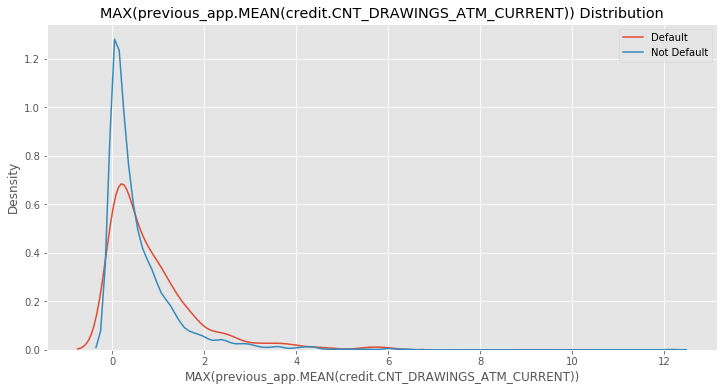

The correlation between MAX(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT)) and the TARGET is 0.0983
Median value for loan that was default = 0.5556
Median value for loan that was not default = 0.3073


In [25]:
kde_target('MAX(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))', features_sample)

### Colinear Features

In [26]:
threshold = 0.9

correlated_pairs = {}

for col in correlations:
    above_threshold_vars = [x for x in list(correlations.index[correlations[col] > threshold]) if x != col]
    correlated_pairs[col] = above_threshold_vars

In [27]:
correlated_pairs['MEAN(credit.CNT_DRAWINGS_ATM_CURRENT)']

['SUM(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))',
 'MAX(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))',
 'MIN(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))',
 'MEAN(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))']

In [28]:
correlations['MEAN(credit.CNT_DRAWINGS_ATM_CURRENT)'].sort_values(ascending = False).head()

Variable
MEAN(credit.CNT_DRAWINGS_ATM_CURRENT)                       1.000000
MIN(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))     0.999917
MEAN(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))    0.999785
MAX(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))     0.998944
SUM(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))     0.998455
Name: MEAN(credit.CNT_DRAWINGS_ATM_CURRENT), dtype: float64

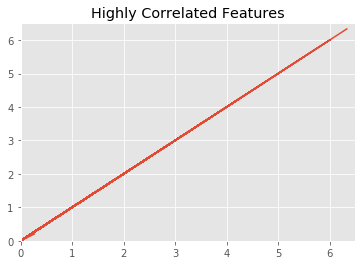

In [36]:
plt.plot(features_sample['MEAN(credit.CNT_DRAWINGS_ATM_CURRENT)'],
        features_sample['MIN(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))'])
plt.title('Highly Correlated Features')
plt.xlim(0,6.5)
plt.ylim(0,6.5)
plt.show()

## Feature importances

In [37]:
fi = pd.read_csv('../home-credit-default-risk/spec_feature_importances_ohe.xls', index_col = 0)
fi = fi.sort_values('importance',ascending = False)
fi.head(15)

,feature,importance
13,EXT_SOURCE_1,357.6
14,EXT_SOURCE_3,311.6
58,EXT_SOURCE_2,307.0
31,DAYS_BIRTH,228.6
55,AMT_CREDIT,204.4
91,AMT_ANNUITY,195.2
69,DAYS_EMPLOYED,150.2
10,AMT_GOODS_PRICE,144.2
186,MAX(bureau.DAYS_CREDIT),138.8
42,DAYS_ID_PUBLISH,122.8


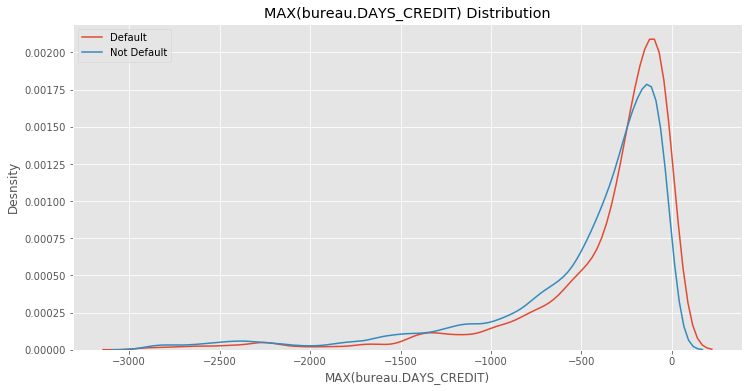

The correlation between MAX(bureau.DAYS_CREDIT) and the TARGET is 0.0555
Median value for loan that was default = -211.5000
Median value for loan that was not default = -304.0000


In [38]:
kde_target('MAX(bureau.DAYS_CREDIT)', features_sample)

In [40]:
original_features = list(pd.get_dummies(app).columns)

created_features = []

for feature in fi['feature'][:100]:
    if feature not in original_features:
        created_features.append(feature)
        
print(' {:d}% of the top 100 features were made by featuretools'.format(len(created_features)))

 78% of the top 100 features were made by featuretools


<BarContainer object of 15 artists>

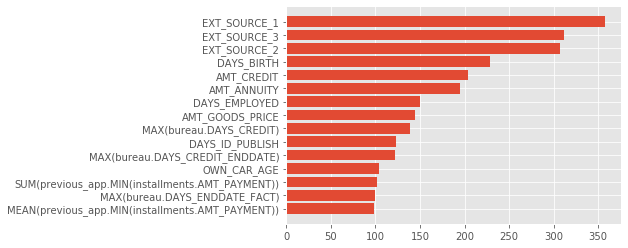

In [46]:
plt.barh(fi['feature'][:15][::-1],fi['importance'][:15][::-1])

In [47]:
print('There ate {:d} features with importance 0'.format(sum(fi['importance'] == 0)))

There ate 237 features with importance 0
